In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

### Loading the data

In [2]:
basepath = '../data_swh/top100'
output_path = '/../results'

fpath = basepath + '/all_data.json'

In [3]:
# read each line of the file as a json object
data_json = []

with open(fpath) as f:
    data_json = [json.loads(line) for line in f]

len(data_json)

890

In [4]:
p_ids = set(p['project_id'] for p in data_json)
len(p_ids)

835

### DataFrame creation
In this notebook, we refer to multi-class licensing with the term "mismatch"

In [6]:
# retrieve the data for each project
ids, language, keywords, n_files, n_licenses, n_unique_licenses, n_mismatches, n_conflicts = [], [], [], [], [], [], [], []
avg_licenses_per_file, avg_unique_licenses_per_file, avg_mismatches_per_file, avg_conflicts_per_file = [], [], [], []

for p in data_json:
    
    ids.append(p['project_id'])

    project_main_language = p['project_main_language']

    if type(project_main_language) == list:
        project_main_language = 'other'

    language.append(project_main_language)
    keywords.append(p['project_keywords'])
    n_files.append(p['n_project_files'])
    n_licenses.append(p['n_project_declared_licenses']+p['n_project_incode_licenses'])
    n_unique_licenses.append(len(p['project_declared_licenses'])+len(p['project_incode_licenses']))
    n_mismatches.append(sum(p['between_declared_mismatches'].values())  + sum(p['between_incode_mismatches'].values()) + sum(p['between_declared_incode_mismatches'].values()))

    tot_conflicts = 0
    tot_conflicts += sum(p['between_declared_conflicts'].values()) + sum(p['possible_between_declared_conflicts'].values())
    tot_conflicts += sum(p['between_incode_conflicts'].values()) + sum(p['possible_between_incode_conflicts'].values())
    tot_conflicts += sum(p['between_declared_incode_conflicts'].values()) + sum(p['possible_between_declared_incode_conflicts'].values())

    n_conflicts.append(tot_conflicts)

    avg_licenses_per_file.append((p['n_project_declared_licenses']+p['n_project_incode_licenses'])/p['n_project_files'])
    avg_unique_licenses_per_file.append((len(p['project_declared_licenses'])+len(p['project_incode_licenses']))/p['n_project_files'])
    avg_mismatches_per_file.append((sum(p['between_declared_mismatches'].values())  + sum(p['between_incode_mismatches'].values()) + sum(p['between_declared_incode_mismatches'].values()))/p['n_project_files'])
    avg_conflicts_per_file.append(tot_conflicts/p['n_project_files'])

In [7]:
# create a dataframe with the data
df = pd.DataFrame({
        'project_id': ids, 
        'language': language, 
        'keywords': keywords, 
        'n_files': n_files, 
        'n_licenses': n_licenses,
        'avg_licenses_per_file': avg_licenses_per_file,
        'n_unique_licenses': n_unique_licenses, 
        'avg_unique_licenses_per_file': avg_unique_licenses_per_file,
        'n_mismatches': n_mismatches, 
        'avg_mismatches_per_file': avg_mismatches_per_file,
        'n_conflicts': n_conflicts,
        'avg_conflicts_per_file': avg_conflicts_per_file
    }
)

In [8]:
df.head()

,project_id,language,keywords,n_files,n_licenses,avg_licenses_per_file,n_unique_licenses,avg_unique_licenses_per_file,n_mismatches,avg_mismatches_per_file,n_conflicts,avg_conflicts_per_file
0,b605819d7976bb2abc1502f1dd0e0f4e86da3301,Java,"[java, spring-boot, spring, framework]",9261,7562,0.816542,6,0.000648,9,0.000972,12,0.001296
1,967e04d66c94a4858b65bfee67349c611f5c669b,TypeScript,"[react, ui-kit, typescript, antd, ant-design, ...",3713,2,0.000539,1,0.000269,0,0.000000,0,0.000000
2,1b14ddaab8a888d31bc8b56de46497453ea35b40,Rich Text Format,"[learn-to-code, git, github, app]",9490,1,0.000105,1,0.000105,0,0.000000,0,0.000000
3,b21667cbe0767257069d8af34424fc411760e350,Python,"[python, algorithm, algorithms-implemented, al...",1347,29,0.021529,4,0.002970,4,0.002970,4,0.002970
4,fe9da48099456119bf5f803518b6d2511106661a,JavaScript,"[javascript, react, frontend, declarative, ui,...",2358,1521,0.645038,4,0.001696,5,0.002120,5,0.002120


In [9]:
# get the number of rows and columns
df.shape

(890, 12)

### Data pre-processing

In [10]:
# reduced keywords
# system -> framework
# 'ui', php, js, jekyll, html -> frontend -> web
# 'learn-to-code', exercise, leetcode, course -> education
# containers, kubernetes -> devops
# search-engine, elasticsearch
# android, ios -> mobile
# library, 'machine-learning', 'deep-learning'-> dev
# database, 'distributed-database', storage -> db
selected_keywords = ['framework', 'education', 'devops', 'web', 'mobile', 'visualization', 'dev', 'db', 'linux', 'compiler', 'networking', 'blockchain', 'iot']

In [11]:
# build a dict with the following
# reduced keywords
# system -> framework
# 'ui', php, js, jekyll, html -> frontend -> web
# 'learn-to-code', exercise, leetcode, course -> education
# containers, kubernetes -> devops
# search-engine, elasticsearch
# android, ios -> mobile
# library, 'machine-learning', 'deep-learning'-> dev
# database, 'distributed-database', storage -> db

same_class = {
    'system': 'framework', 
    'ui': 'web', 
    'ui-library': 'web',
    'php': 'web', 
    'js': 'web', 
    'jekyll': 'web', 
    'html': 'web', 
    'spring': 'web',
    'webpack': 'web',
    'html5': 'web',
    'aspnet': 'web',
    'react': 'web',
    'hosting': 'web',
    'http3': 'web',
    'progressive-web-app': 'web',
    'weapp': 'web',
    'crawler': 'web',
    'django': 'web',
    'angularjs': 'web',
    'node': 'web',
    'webm': 'web',
    'picker': 'web',
    'css': 'web',
    'api-server': 'web',
    'javascript': 'web',
    'webassembly': 'web',
    'static-site-generator': 'web',
    'website-generation': 'web',
    'apache': 'web',
    'web-app': 'web',
    'learn-to-code': 'education', 
    'learning': 'education',
    'exercise': 'education', 
    'leetcode': 'education', 
    'course': 'education', 
    'computer-science': 'education',
    'readme-template': 'education',
    'interview-questions': 'education',
    'teaching': 'education',
    'beginner-friendly': 'education',
    'book': 'education',
    'tutorials': 'education',
    'containers': 'devops', 
    'kubernetes': 'devops', 
    'search-engine': 'search-engine', 
    'elasticsearch': 'search-engine', 
    'chrome-extension': 'search-engine',
    'chromium': 'search-engine',
    'computer-graphics': 'visualization',
    'dataviz': 'visualization',
    'heatmap': 'visualization',
    'dashboard': 'visualization',
    'data-visualization': 'visualization',
    'generativeart': 'visualization',
    'visualisation': 'visualization',
    'image-processing': 'visualization',
    'tooltip': 'visualization',
    'progressbar': 'visualization',
    'palette': 'visualization',
    'video-transcoding': 'visualization',
    'colors': 'visualization',
    'tui': 'visualization',
    'plot': 'visualization',
    'android': 'mobile', 
    'ios': 'mobile', 
    'library': 'dev', 
    'development': 'dev',
    'emulator': 'dev',
    'python-library': 'dev',
    'machine-learning': 'dev', 
    'game': 'dev',
    'gtk-rs': 'dev',
    'desktop': 'dev',
    'syntax-highlighter': 'dev',
    'package-manager': 'dev',
    'programming-language': 'dev',
    'code-quality': 'dev',
    'dataframe': 'dev',
    'styleguide': 'dev',
    'profiler': 'dev',
    'deep-learning': 'dev', 
    'chatbot': 'dev',
    'artificial-intelligence': 'dev',
    'data-manipulation': 'dev',
    'network-analysis': 'dev',
    'data-science': 'dev',
    'scientific-machine-learning': 'dev',
    'text-mining': 'dev',
    'linter': 'dev',
    'parser': 'dev',
    'visual-studio-code': 'dev',
    'bayesian-inference': 'dev',
    'performance-analysis': 'dev',
    'nlp': 'dev',
    'functional-programming': 'dev',
    'neural-networks': 'dev',
    'literate-programming': 'dev',
    'mathematical-programming': 'dev',
    'jupyter': 'dev',
    'statistics': 'dev',
    'tensor': 'dev',
    'forecasting': 'dev',
    'csv': 'dev',
    'quantum-toolbox': 'dev',
    'clipboard': 'dev',
    'parallel-computing': 'dev',
    'data-manipulation': 'dev',
    'interpolation': 'dev',
    'optimization': 'dev',
    'cpp': 'dev',
    'pytorch': 'dev',
    'transformer': 'dev',
    'pdf-viewer': 'dev',
    'python-compiler': 'dev',
    'continuous-integration': 'dev',
    'packagecompiler': 'dev',
    'interoperability': 'dev',
    'numerical-methods': 'dev',
    'julia': 'dev',
    'javabeans': 'dev',
    'gpgpu': 'dev',
    'graph': 'dev',
    'solver': 'dev',
    'intellij': 'dev',
    'unit-testing': 'dev',
    'spatial': 'dev',
    'database': 'db', 
    'distributed-database': 'db', 
    'datalake': 'db',
    'juliadb': 'db',
    'cloud-storage': 'db',
    'postgresql': 'db',
    'mysql': 'db',
    'storage': 'db',
    'sql': 'db',
    'hacktoberfest': 'events',
    'bitcoin': 'blockchain',
    'internet-of-things': 'iot',
    'arduino': 'iot',
    'raspberry': 'iot',
    'embedded': 'iot',
    'iptv': 'networking',
    'protocol': 'networking',
    'chat': 'networking',
    'firewall': 'networking',
    'curl': 'networking',
    'proxy': 'networking',
    'ssl-vpn': 'networking',
    'openssl': 'networking',
    'cryptography': 'networking',
    'security': 'networking',
    'springcloud': 'networking',
    'hadoop': 'networking',
    'vim': 'linux',
    'cli': 'linux',
    'terminal': 'linux',
    'shell': 'linux',
    'coreutils': 'linux',
    'command-line': 'linux',
    'powershell': 'linux',
    'secure-boot': 'linux',
    'command-line-tool': 'linux',
    'driver': 'linux',
    'system-software': 'linux',
    'android-library': 'mobile',
    'android-webview': 'mobile',
    'kotlin': 'mobile',
}

In [12]:
# based on the selected keywords, create a new column with the reduced keywords
reduced_keywords = []

for ks in keywords:
    reduced = []
    
    for k in ks:
        if k in selected_keywords:
            reduced.append(k)
            break
        else:
            dopplenganger = same_class.get(k)
            if dopplenganger:
                reduced.append(dopplenganger)
                break
    
    if len(reduced) == 0:
        reduced_keywords.append(ks)
    else:
        reduced_keywords.append(reduced)

reduced_keywords        

[['web'],
 ['web'],
 ['education'],
 ['education'],
 ['web'],
 ['devops'],
 ['web'],
 ['dev'],
 [],
 [],
 ['events'],
 ['search-engine'],
 ['mobile'],
 ['web'],
 ['education'],
 ['dev'],
 ['visualization'],
 ['dev'],
 ['web'],
 ['web'],
 [],
 ['dev'],
 ['db'],
 [],
 ['education'],
 [],
 [],
 ['web'],
 [],
 [],
 ['education'],
 ['education'],
 ['framework'],
 ['web'],
 ['blockchain'],
 [],
 ['web'],
 [],
 ['education'],
 ['events'],
 [],
 ['dev'],
 ['iot'],
 [],
 ['web'],
 ['gitignore', 'git'],
 [],
 [],
 ['education'],
 [],
 [],
 [],
 ['education'],
 ['db'],
 ['dev'],
 ['framework'],
 ['db'],
 ['web'],
 ['awesome', 'awesome-list', 'unicorns', 'lists', 'resources'],
 ['web'],
 ['web'],
 ['web'],
 [],
 [],
 ['web'],
 ['dev'],
 ['dev'],
 [],
 ['events'],
 ['web'],
 ['dev'],
 ['web'],
 ['mobile'],
 ['iot'],
 ['web'],
 ['linux'],
 ['events'],
 ['dev'],
 ['linux'],
 ['web'],
 ['events'],
 ['dev'],
 [],
 ['education'],
 ['education'],
 [],
 ['education'],
 [],
 [],
 [],
 ['events'],
 ['web'],

In [13]:
revised_keywords = [ks[0] if len(ks) == 1 else 'other' for ks in reduced_keywords]

In [14]:
revised_keywords

['web',
 'web',
 'education',
 'education',
 'web',
 'devops',
 'web',
 'dev',
 'other',
 'other',
 'events',
 'search-engine',
 'mobile',
 'web',
 'education',
 'dev',
 'visualization',
 'dev',
 'web',
 'web',
 'other',
 'dev',
 'db',
 'other',
 'education',
 'other',
 'other',
 'web',
 'other',
 'other',
 'education',
 'education',
 'framework',
 'web',
 'blockchain',
 'other',
 'web',
 'other',
 'education',
 'events',
 'other',
 'dev',
 'iot',
 'other',
 'web',
 'other',
 'other',
 'other',
 'education',
 'other',
 'other',
 'other',
 'education',
 'db',
 'dev',
 'framework',
 'db',
 'web',
 'other',
 'web',
 'web',
 'web',
 'other',
 'other',
 'web',
 'dev',
 'dev',
 'other',
 'events',
 'web',
 'dev',
 'web',
 'mobile',
 'iot',
 'web',
 'linux',
 'events',
 'dev',
 'linux',
 'web',
 'events',
 'dev',
 'other',
 'education',
 'education',
 'other',
 'education',
 'other',
 'other',
 'other',
 'events',
 'web',
 'networking',
 'events',
 'other',
 'networking',
 'education',
 'educ

In [15]:
df['selected_keywords'] = revised_keywords

In [16]:
df.head()

,project_id,language,keywords,n_files,n_licenses,avg_licenses_per_file,n_unique_licenses,avg_unique_licenses_per_file,n_mismatches,avg_mismatches_per_file,n_conflicts,avg_conflicts_per_file,selected_keywords
0,b605819d7976bb2abc1502f1dd0e0f4e86da3301,Java,"[java, spring-boot, spring, framework]",9261,7562,0.816542,6,0.000648,9,0.000972,12,0.001296,web
1,967e04d66c94a4858b65bfee67349c611f5c669b,TypeScript,"[react, ui-kit, typescript, antd, ant-design, ...",3713,2,0.000539,1,0.000269,0,0.000000,0,0.000000,web
2,1b14ddaab8a888d31bc8b56de46497453ea35b40,Rich Text Format,"[learn-to-code, git, github, app]",9490,1,0.000105,1,0.000105,0,0.000000,0,0.000000,education
3,b21667cbe0767257069d8af34424fc411760e350,Python,"[python, algorithm, algorithms-implemented, al...",1347,29,0.021529,4,0.002970,4,0.002970,4,0.002970,education
4,fe9da48099456119bf5f803518b6d2511106661a,JavaScript,"[javascript, react, frontend, declarative, ui,...",2358,1521,0.645038,4,0.001696,5,0.002120,5,0.002120,web


#### Select domains to analyze

In [17]:
# we want to know how many different languages are used in each application domain
# and how many projects are in each application domain
grouped_df_by_domain = df.groupby('selected_keywords')

In [18]:
# get how many projects are in each application domain
n_projects_per_domain = grouped_df_by_domain['project_id'].count()

In [19]:
n_projects_per_domain.values

array([  8,   4,  23, 179,   6,  33,  33,   7,   9,   1,   1,   1,  45,
        96,  19, 277,   1,   1,   8,  28, 110])

In [20]:
np.quantile(n_projects_per_domain.values, [0.25, 0.5, 0.75])

array([ 4.,  9., 33.])

In [21]:
# get how many different languages are used in each application domain
for group in grouped_df_by_domain:
    # skip groups with less than 30 projects
    if len(group[1]) < 30:
        continue
    
    print(group[0])

    #languages = group[1]['language'].tolist()
    #print(languages)
    

dev
education
events
linux
mobile
other
web


### Correlation between application domain and liceses usage, mismatches, and conflicts

In [23]:
# get all application domains
app_domains = sorted(set(df['selected_keywords']))
app_domains

['blockchain',
 'compiler',
 'db',
 'dev',
 'devops',
 'education',
 'events',
 'framework',
 'iot',
 'jq',
 'jquery',
 'kernel',
 'linux',
 'mobile',
 'networking',
 'other',
 'paper',
 'r',
 'search-engine',
 'visualization',
 'web']

In [158]:
# remove the 'Other' element
# app_domains.remove('Other')
# app_domains

In [24]:
app_domains_analyzed = []

n_licenses_per_app_domain = []
n_unique_licenses_per_app_domain = []
n_mismatches_per_app_domain = []
n_conflicts_per_app_domain = []

avg_licenses_per_file_per_app_domain = []
avg_unique_licenses_per_file_per_app_domain = []
avg_mismatches_per_file_per_app_domain = []
avg_conflicts_per_file_per_app_domain = []

languages_per_app_domain = []

for i, app_domain in enumerate(app_domains):
    print(i, app_domain)
    _df = df[df['selected_keywords'] == app_domain]

    if len(_df) < 30:
        continue

    app_domains_analyzed.append(app_domain)

    _n_licenses = _df['n_licenses'].tolist()
    _n_unique_licenses = _df['n_unique_licenses'].tolist()
    _n_mismatches = _df['n_mismatches'].tolist()
    _n_conflicts = _df['n_conflicts'].tolist()

    _avg_licenses_per_file = _df['avg_licenses_per_file'].tolist()
    _avg_unique_licenses_per_file = _df['avg_unique_licenses_per_file'].tolist()
    _avg_mismatches_per_file = _df['avg_mismatches_per_file'].tolist()
    _avg_conflicts_per_file = _df['avg_conflicts_per_file'].tolist()

    _languages_per_app_domain = _df['language'].tolist()

    n_licenses_per_app_domain.append(_n_licenses)
    n_unique_licenses_per_app_domain.append(_n_unique_licenses)
    n_mismatches_per_app_domain.append(_n_mismatches)
    n_conflicts_per_app_domain.append(_n_conflicts)

    avg_licenses_per_file_per_app_domain.append(_avg_licenses_per_file)
    avg_unique_licenses_per_file_per_app_domain.append(_avg_unique_licenses_per_file)
    avg_mismatches_per_file_per_app_domain.append(_avg_mismatches_per_file)
    avg_conflicts_per_file_per_app_domain.append(_avg_conflicts_per_file)

    languages_per_app_domain.append(_languages_per_app_domain)

app_domains_analyzed

0 blockchain
1 compiler
2 db
3 dev
4 devops
5 education
6 events
7 framework
8 iot
9 jq
10 jquery
11 kernel
12 linux
13 mobile
14 networking
15 other
16 paper
17 r
18 search-engine
19 visualization
20 web


['dev', 'education', 'events', 'linux', 'mobile', 'other', 'web']

In [25]:
# now we want to examine whether the a specific application domain
# is correlated with the number of licenses, mismatches, and conflicts

h_statistic_n_licenses, p_value_n_licenses = stats.kruskal(*avg_licenses_per_file_per_app_domain)
print('N_licenses: ', h_statistic_n_licenses, p_value_n_licenses)

h_statistic_n_licenses, p_value_n_licenses = stats.kruskal(*avg_unique_licenses_per_file_per_app_domain)
print('N_licenses: ', h_statistic_n_licenses, p_value_n_licenses)

h_statistic_n_mismatches, p_value_n_mismatches = stats.kruskal(*avg_mismatches_per_file_per_app_domain)
print('N_mismatches: ',h_statistic_n_mismatches, p_value_n_mismatches)

h_statistic_n_conflicts, p_value_n_conflicts = stats.kruskal(*avg_conflicts_per_file_per_app_domain)
print('N_conflicts: ',h_statistic_n_conflicts, p_value_n_conflicts)

N_licenses:  39.30433225533475 6.238655040755418e-07
N_licenses:  37.30193654418705 1.5376181766449406e-06
N_mismatches:  33.564537149435374 8.163360448244487e-06
N_conflicts:  42.54230997417502 1.4367624025529638e-07


In [26]:
# now we want to examine whether the a specific application domain
# is correlated with the number of licenses, mismatches, and conflicts

h_statistic_n_licenses, p_value_n_licenses = stats.kruskal(*n_licenses_per_app_domain)
print('N_licenses: ', h_statistic_n_licenses, p_value_n_licenses)

h_statistic_n_mismatches, p_value_n_mismatches = stats.kruskal(*n_mismatches_per_app_domain)
print('N_mismatches: ',h_statistic_n_mismatches, p_value_n_mismatches)

h_statistic_n_conflicts, p_value_n_conflicts = stats.kruskal(*n_conflicts_per_app_domain)
print('N_conflicts: ',h_statistic_n_conflicts, p_value_n_conflicts)

N_licenses:  52.18405072751128 1.7124646342881341e-09
N_mismatches:  42.76805936461221 1.2964219408547958e-07
N_conflicts:  49.126655795584234 7.033169726225578e-09


### Which languages compose each domain?

In [30]:
# zip the app_domains_analyzed with n_licenses_per_app_domain, n_mismatches_per_app_domain, and n_conflicts_per_app_domain
# and sort them alphabetically
lang_zipped_results = sorted(
    zip(
        app_domains_analyzed, 
        languages_per_app_domain
    ), key=lambda x: x[0])
lang_zipped_results;

In [31]:
_languages_analyzed = ['C', 'Java', 'JavaScript', 'Julia', 'Kotlin', 'Python', 'R', 'Rust']

In [32]:
# init data_to_plot as a dict with keys from _languages analyzed
# and values as empty lists
data_to_plot = {_l: [] for _l in _languages_analyzed}
data_to_plot

{'C': [],
 'Java': [],
 'JavaScript': [],
 'Julia': [],
 'Kotlin': [],
 'Python': [],
 'R': [],
 'Rust': []}

In [33]:
for app_dom, all_langs in lang_zipped_results:
    print(app_dom)
    tot_lang = len(all_langs)
    langs = set(all_langs)

    for l in _languages_analyzed:
        # if l not in langs:
        #     continue
        # how many instances of l are in all_langs
        n_l = all_langs.count(l)
        print(l, (n_l/tot_lang)*100)
        data_to_plot[l].append((n_l/tot_lang)*100)

    print("-------------------")

dev
C 3.910614525139665
Java 2.2346368715083798
JavaScript 3.35195530726257
Julia 34.63687150837989
Kotlin 2.2346368715083798
Python 21.787709497206702
R 17.318435754189945
Rust 7.82122905027933
-------------------
education
C 6.0606060606060606
Java 3.0303030303030303
JavaScript 3.0303030303030303
Julia 0.0
Kotlin 0.0
Python 9.090909090909092
R 9.090909090909092
Rust 9.090909090909092
-------------------
events
C 12.121212121212121
Java 12.121212121212121
JavaScript 3.0303030303030303
Julia 6.0606060606060606
Kotlin 6.0606060606060606
Python 9.090909090909092
R 3.0303030303030303
Rust 33.33333333333333
-------------------
linux
C 26.666666666666668
Java 0.0
JavaScript 2.2222222222222223
Julia 0.0
Kotlin 0.0
Python 13.333333333333334
R 0.0
Rust 46.666666666666664
-------------------
mobile
C 4.166666666666666
Java 34.375
JavaScript 0.0
Julia 0.0
Kotlin 58.333333333333336
Python 0.0
R 0.0
Rust 1.0416666666666665
-------------------
other
C 12.274368231046932
Java 13.357400722021662
Java

In [35]:
data_to_plot;

In [36]:
_app_domains_analyzed = [
    'Dev',
    'Edu.',
    'Events',
    'OS',
    'Mobile',
    'Other',
    'Web'       
]

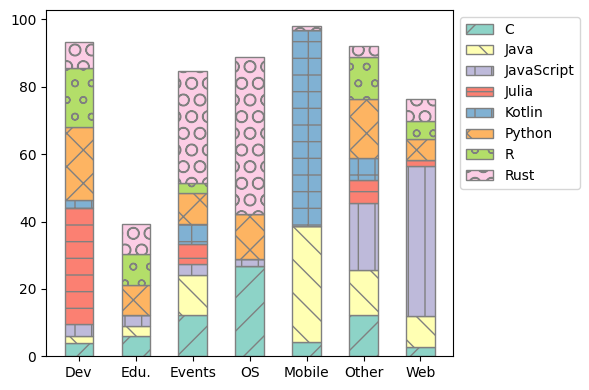

In [38]:
# build a stacked bar chart with the number of projects per application domain
plt.rcParams['hatch.color'] = 'gray'

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
bottom = np.zeros(len(app_domains_analyzed))

width = 0.5
_colors = plt.get_cmap('Set3').colors
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

for idx, (lang, lang_percentage) in enumerate(data_to_plot.items()):
    p = ax.bar(
        _app_domains_analyzed, 
        lang_percentage, 
        width, 
        label=lang, 
        bottom=bottom, 
        color=_colors[idx], 
        edgecolor='gray', 
        hatch=patterns[idx]
    )
    bottom += lang_percentage

# legend up
ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.tight_layout();
plt.savefig('lang_per_domain.png', dpi=300)

### Which group differ? NORMALIZED

In [39]:
# zip the app_domains_analyzed with n_licenses_per_app_domain, n_mismatches_per_app_domain, and n_conflicts_per_app_domain
# and sort them alphabetically
zipped_results = sorted(
    zip(
        app_domains_analyzed, 
        avg_licenses_per_file_per_app_domain, 
        avg_mismatches_per_file_per_app_domain, 
        avg_conflicts_per_file_per_app_domain
    ), key=lambda x: x[0])
zipped_results;

In [40]:
_app_domains_analyzed = [
    'Dev',
    'Education',
    'Events',
    'OS',
    'Mobile',
    'Other',
    'Web'       
]

In [41]:
ad_labels = [z[0] for z in zipped_results]
ad_n_licenses = [z[1] for z in zipped_results]
ad_n_mismatches = [z[2] for z in zipped_results]
ad_n_conflicts = [z[3] for z in zipped_results]

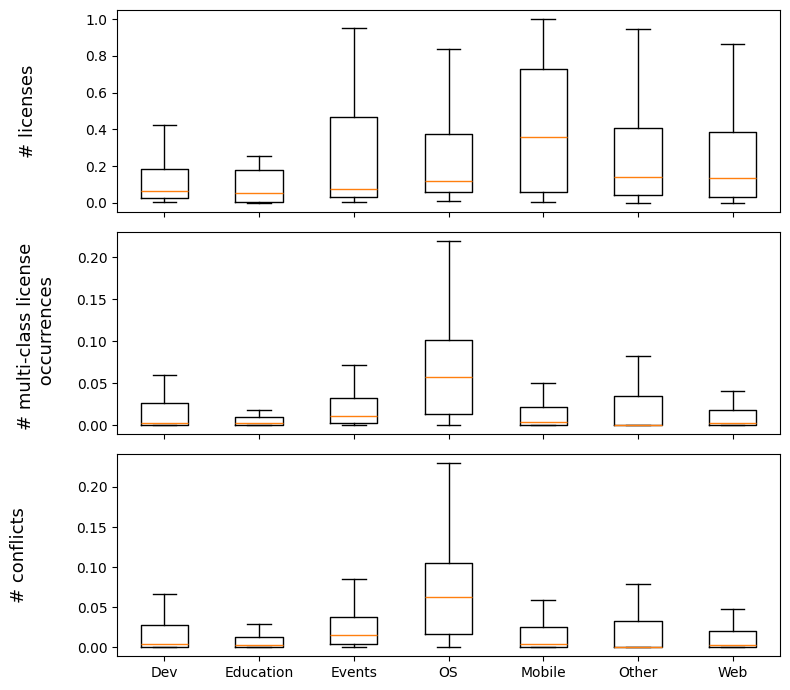

In [50]:
# I want to visualize all plots together
# using boxplots

fig, ax = plt.subplots(3, 1, figsize=(8, 7))

axs_size = 13

ax[0].boxplot(ad_n_licenses, showfliers=False)
# do not show xtickslabel
ax[0].set_xticklabels([])
ax[0].xaxis.label.set_size(axs_size)
ax[0].yaxis.label.set_size(axs_size)
ax[0].set_ylabel('# licenses\n', labelpad=20)

ax[1].boxplot(ad_n_mismatches, showfliers=False)
ax[1].set_xticklabels([])
ax[1].xaxis.label.set_size(axs_size)
ax[1].yaxis.label.set_size(axs_size)
ax[1].set_ylabel('# multi-class license \n occurrences', labelpad=15)

ax[2].boxplot(ad_n_conflicts, labels=_app_domains_analyzed, showfliers=False)
ax[2].xaxis.label.set_size(axs_size)
ax[2].yaxis.label.set_size(axs_size)
ax[2].set_ylabel('# conflicts\n', labelpad=20)


#ax[0].set_title('Number of licenses, mismatches, and conflicts per application domain')

plt.tight_layout();
plt.savefig('number_licenses_mismatches_conflicts_per_domain_rev2.png')


In [45]:
# now we want to know which groups are statistically different from each other
# we use the Mann-Whitney U test

alpha = 0.05

# n_licenses
for i in range(len(avg_licenses_per_file_per_app_domain)):
    for j in range(i+1, len(avg_licenses_per_file_per_app_domain)):
        print(app_domains_analyzed[i], app_domains_analyzed[j])
        h_statistic, p_value = stats.mannwhitneyu(avg_licenses_per_file_per_app_domain[i], avg_licenses_per_file_per_app_domain[j])

        print(h_statistic, p_value, len(avg_licenses_per_file_per_app_domain[i]), len(avg_licenses_per_file_per_app_domain[j]))

        if p_value < alpha:
            print('Significant')

        print('***')

dev education
3492.5 0.09630122717799973 179 33
***
dev events
2689.0 0.4148920971840254 179 33
***
dev linux
2954.0 0.00576198396817499 179 45
Significant
***
dev mobile
5501.0 8.8365412053498e-07 179 96
Significant
***
dev other
20117.0 0.0006703962787916833 179 277
Significant
***
dev web
8658.0 0.08542325743519354 179 110
***
education events
403.0 0.07055590706082972 33 33
***
education linux
453.0 0.003467019345077121 33 45
Significant
***
education mobile
800.5 2.372363232505284e-05 33 96
Significant
***
education other
3152.0 0.003575300159438107 33 277
Significant
***
education web
1325.0 0.01900487459489085 33 110
Significant
***
events linux
654.5 0.3761620066445579 33 45
***
events mobile
1155.0 0.02072147322456019 33 96
Significant
***
events other
4287.0 0.5609418127644861 33 277
***
events web
1818.0 0.9904425651967321 33 110
***
linux mobile
1727.0 0.0557604348002438 45 96
***
linux other
6502.5 0.6417350449824732 45 277
***
linux web
2752.5 0.27483774155490925 45 110
*

In [46]:
# now we want to know which groups are statistically different from each other
# we use the Mann-Whitney U test

alpha = 0.05

# n_licenses
for i in range(len(avg_mismatches_per_file_per_app_domain)):
    for j in range(i+1, len(avg_mismatches_per_file_per_app_domain)):
        print(app_domains_analyzed[i], app_domains_analyzed[j])
        h_statistic, p_value = stats.mannwhitneyu(avg_mismatches_per_file_per_app_domain[i], avg_mismatches_per_file_per_app_domain[j])

        print(h_statistic, p_value, len(avg_mismatches_per_file_per_app_domain[i]), len(avg_mismatches_per_file_per_app_domain[j]))

        if p_value < alpha:
            print('Significant')

        print('***')

dev education
3078.0 0.6921649155142025 179 33
***
dev events
2272.0 0.030617290614990574 179 33
Significant
***
dev linux
2182.0 1.098890619714082e-06 179 45
Significant
***
dev mobile
8514.5 0.899258669601184 179 96
***
dev other
25649.5 0.5073991178796842 179 277
***
dev web
10250.0 0.5428032396192585 179 110
***
education events
370.0 0.024400987552201173 33 33
Significant
***
education linux
379.5 0.00021769499733611774 33 45
Significant
***
education mobile
1487.0 0.5933636648400793 33 96
***
education other
4746.0 0.6994939822820121 33 277
***
education web
1830.5 0.9408035332048333 33 110
***
events linux
503.0 0.015272743540052014 33 45
Significant
***
events mobile
1961.5 0.038353325057494746 33 96
Significant
***
events other
5624.0 0.021082107199848963 33 277
Significant
***
events web
2342.0 0.009721966691264345 33 110
Significant
***
linux mobile
3204.5 2.6739306751730547e-06 45 96
Significant
***
linux other
8776.5 3.0965522470736675e-06 45 277
Significant
***
linux web


In [47]:
# now we want to know which groups are statistically different from each other
# we use the Mann-Whitney U test

alpha = 0.05

# n_licenses
for i in range(len(avg_conflicts_per_file_per_app_domain)):
    for j in range(len(avg_conflicts_per_file_per_app_domain)):
        print(app_domains_analyzed[i], app_domains_analyzed[j])
        h_statistic, p_value = stats.mannwhitneyu(avg_conflicts_per_file_per_app_domain[i], avg_conflicts_per_file_per_app_domain[j])

        print(h_statistic, p_value, len(avg_conflicts_per_file_per_app_domain[i]), len(avg_conflicts_per_file_per_app_domain[j]))

        if p_value < alpha:
            print('Significant')

        print('***')

dev dev
16020.5 1.0 179 179
***
dev education
3137.5 0.5574602579345056 179 33
***
dev events
2155.0 0.011380340256915684 179 33
Significant
***
dev linux
2039.0 1.5567250346938788e-07 179 45
Significant
***
dev mobile
8366.5 0.7119389571176676 179 96
***
dev other
26247.0 0.25983707709806225 179 277
***
dev web
10209.0 0.5851620198247148 179 110
***
education dev
2769.5 0.5574602579345056 33 179
***
education education
544.5 1.0 33 33
***
education events
331.0 0.005864982296572119 33 33
Significant
***
education linux
343.5 4.8089568292674766e-05 33 45
Significant
***
education mobile
1428.5 0.39182607041227047 33 96
***
education other
4730.5 0.7238010962760192 33 277
***
education web
1765.0 0.8067422618684994 33 110
***
events dev
3752.0 0.011380340256915684 33 179
Significant
***
events education
758.0 0.005864982296572119 33 33
Significant
***
events events
544.5 1.0 33 33
***
events linux
507.0 0.017207475171053144 33 45
Significant
***
events mobile
2015.0 0.018443996942939397